In [87]:
import pandas as pd
import numpy as np

import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

In [88]:
df = pd.read_csv("Annotation-data-test.csv")

In [89]:
df = df.drop('Unnamed: 0', 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_22176/3812631323.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 0', 1)


In [90]:
cols = df.iloc[:, 9:12]

In [91]:
def get_labels(row):
    for col in cols:
        if row[col] == 1:
            return col

df['Labels'] = df.apply(get_labels, axis=1)

In [92]:
df = df.drop(['id', 'post.nr', 'date', 'phaseType', 'Machine_Translation', 'toxicity', 'severe_toxicity', 'lab_toxic', 'lab_undetermined', 'lab_not_toxic'], axis = 1)

In [93]:
df['comment_text'] = df['comment.text']

In [94]:
df = df.drop(['comment.text'], axis = 1)

In [95]:
df

,n,Labels,comment_text
0,51,lab_not_toxic,fick just samtal att en lastbil kört över mass...
1,116,lab_not_toxic,andra trådar kopplade till terrorattentatet på...
2,15,lab_not_toxic,har även jag hört från en på plats nya spänna...
3,17,lab_not_toxic,enligt nyhetsflash från aftonbladet har en las...
4,1,lab_not_toxic,terrorattack
...,...,...,...
14593,11,None,muhammad mördade både kvinnor barn och äldre ...
14594,261,None,tack för ditt intressanta inlägg det är rel...
14595,23,None,problemet är att sverige har ingen skarprättar...
14596,60,None,även en blind höna hittar ett korn dvs det är...


In [96]:
df = df.dropna()

In [97]:
df = df[df['Labels'] != 'lab_undetermined']

In [98]:
le = LabelEncoder()
df['Labels'] = le.fit_transform(df['Labels'])

In [99]:
df

,n,Labels,comment_text
0,51,0,fick just samtal att en lastbil kört över mass...
1,116,0,andra trådar kopplade till terrorattentatet på...
2,15,0,har även jag hört från en på plats nya spänna...
3,17,0,enligt nyhetsflash från aftonbladet har en las...
4,1,0,terrorattack
...,...,...,...
5394,36,0,nä men den stora anledningen till att han gri...
5395,53,0,för att inte bli identifierad alls under själv...
5396,60,0,har någon några uppgifter hurvida det var en s...
5397,42,0,varför gm hade rånarluva vet jag inte men jag...


<AxesSubplot:>

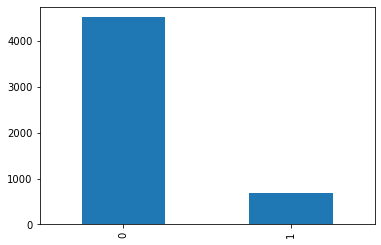

In [100]:
df['Labels'].value_counts().plot(kind='bar')

In [106]:
def augment_sentence(sentence, aug, num_threads):
    """""""""
    Constructs a new sentence via text augmentation.
    
    Input:
        - sentence:     A string of text
        - aug:          An augmentation object defined by the nlpaug library
        - num_threads:  Integer controlling the number of threads to use if
                        augmenting text via CPU
    Output:
        - A string of text that been augmented
    """""""""
    return aug.augment(sentence, num_thread=num_threads)
    


def augment_text(df, aug, num_threads, num_times):
    """""""""
    Takes a pandas DataFrame and augments its text data.
    
    Input:
        - df:            A pandas DataFrame containing the columns:
                                - 'comment_text' containing strings of text to augment.
                                - 'isToxic' binary target variable containing 0's and 1's.
        - aug:           Augmentation object defined by the nlpaug library.
        - num_threads:   Integer controlling number of threads to use if augmenting
                         text via CPU
        - num_times:     Integer representing the number of times to augment text.
    Output:
        - df:            Copy of the same pandas DataFrame with augmented data 
                         appended to it and with rows randomly shuffled.
    """""""""
    
    # Get rows of data to augment
    to_augment = df[df['Labels']==1]
    to_augmentX = to_augment['comment_text']
    to_augmentY = np.ones(len(to_augmentX.index) * num_times, dtype=np.int8)
    
    # Build up dictionary containing augmented data
    aug_dict = {'comment_text':[], 'Labels':to_augmentY}
    for i in tqdm(range(num_times)):
        augX = [augment_sentence(x, aug, num_threads) for x in to_augmentX]
        aug_dict['comment_text'].extend(augX)
    
    # Build DataFrame containing augmented data
    aug_df = pd.DataFrame.from_dict(aug_dict)
    
    return df.append(aug_df, ignore_index=True).sample(frac=1, random_state=42)

In [107]:
aug10p = nlpaw.ContextualWordEmbsAug(model_path='KB/bert-base-swedish-cased', aug_min=1, aug_p=0.1, action="substitute")

In [108]:
balanced_df = augment_text(df, aug10p, num_threads=4, num_times=5)

100%|██████████| 5/5 [54:15<00:00, 651.17s/it]


In [109]:
balanced_df

,n,Labels,comment_text
3260,25.0,0,kan ju också varit så att det var riksdagen so...
239,12.0,0,sverige har haft många terrordåd innan bland ...
3245,31.0,1,fattar inte varför folk hänger upp sig på att ...
3393,16.0,0,rapporterade avpixlat om för någon timme sedan...
540,24.0,0,hemskt det som hänt undra om det kommer en an...
...,...,...,...
5734,NaN,1,Det har bara kommit från avpixlat jag har inte...
5191,43.0,0,största anledningen till det lyckade gripet är...
5390,NaN,1,vad fan hjälper det han fick god tid på sig at...
860,24.0,0,hade lika gärna kunnat vara en själv som drabb...


<AxesSubplot:>

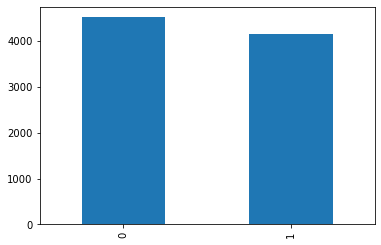

In [110]:
balanced_df['Labels'].value_counts().plot(kind='bar')

In [111]:
balanced_df.to_csv('df-for-bert.csv', index = True, encoding = 'utf-8-sig')